# url2vec

In [1]:
import os
import numpy as np
import pandas as pd
import sys
sys.path.append(os.path.abspath(".."))

import plotly.plotly as py
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from url2vec.util.plotter import *
from url2vec.model.urlembed import *
from url2vec.util.seqmanager import *

from __future__ import print_function

### Loading files
Here we're loading all the files previously crawled.

See the [Dataset README](https://github.com/chrisPiemonte/url2vec/tree/master/dataset "Dataset") for further information.

Here we're creating a dict that associates a code to every URL (**codecontent_map**), a generator (**sequences**) that yields a sequence at each iteration and a list of "cluster membership" (**ground_truth**) for each URL passed, in order of how the dict would be iterated.

In [2]:
# dir_path = os.getcwd() + "/../dataset/cs.illinois.edu/no_constraint/words1000_depth10/"
dir_path = os.getcwd() + "/../dataset/cs.ox.ac.uk/list_constraint/words10000_depth5/"

vertex_path   = dir_path + "vertex.txt"
documents_map = get_content_map(vertex_path)

map_path      = dir_path + "urlsMap.txt"
urls_map      = get_urlmap(map_path)

walks_path    = dir_path + "sequenceIDs.txt"
walks         = get_sequences(walks_path)


#### Training
A simple case would be like this:

Her we're passing only the sequences and the page contents, and left unchanged the remaining parameters.
By doing the training in this way, the model maps each URL to a combined vector, derived from a 48-dimensional array from the word2vec model and a 50-dimensional array from the tf-idf matrix.

In this manner we are considering both the page content of a URL and the its feature vector from the word2vec algorithm.

In [3]:
model = Url2Vec()
predicted_labels = model.fit_predict(algorithm=KMeans(n_clusters=28), walks=walks, documents=documents_map)

gt = GroundTruth(os.getcwd() + "/../dataset/cs.ox.ac.uk/ground_truth/urlToMembership.txt")
ground_truth = [ int(gt.get_groundtruth(urls_map[code])) for code in model.urls ]
len(ground_truth)

len(predicted_labels)

Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url not found
Url no

3149

Now we have the predicted labels, clustered with the HDBSCAN algorithm (default):

In [4]:
print("Clusters found with Kmeans:", len(set(predicted_labels)))
print(set(predicted_labels), "\n")
print(predicted_labels[:15])

print("\n\n")

Clusters found with Kmeans: 28
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]) 

[1, 13, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 17, 10]





#### Confusion table
Now we can have the confusion table by passing the ground truth:

In [5]:
conf_table = model.test(ground_truth)
pd.DataFrame(conf_table, index=set(ground_truth), columns=set(predicted_labels))

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,5.0,0.0,11.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,1.0,0.0,0.0,3.0,0.0,6.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,0.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,3.0,5.0,0.0,45.0,0.0,9.0,11.0,1.0,0.0
7,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.0,0.0,5.0,3.0,0.0,0.0,0.0,14.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Other metrics
Or have other evaluation scores:

In [6]:
homogeneity     = model.homogeneity_score()
completeness    = model.completeness_score()
v_measure       = model.v_measure_score()
adj_rand        = model.adjusted_rand_score()
adj_mutual_info = model.adjusted_mutual_info_score()
silhouette      = model.silhouette_score()

pd.DataFrame({
        "Homogeneity":homogeneity, 
        "Completeness":completeness, 
        "V-Measure":v_measure, 
        "Adj Rand index":adj_rand, 
        "Adj Mutual info":adj_mutual_info, 
        "Silhouette":silhouette
    },
    index=["Model Scores"]
)

,Adj Mutual info,Adj Rand index,Completeness,Homogeneity,Silhouette,V-Measure
Model Scores,0.469261,0.286305,0.485612,0.711716,0.200996,0.577315


We can even get the two-dimensional array of the training for plotting it

In [7]:
twodim = model.two_dim()
twodim[:5]

array([[-15.93160677,   8.64956937],
       [  6.13910137, -12.90524582],
       [ -0.09038982,  17.26110348],
       [ -7.56741849, -14.24806391],
       [ -8.08897815, -11.83586854]])

A wild plot appears:

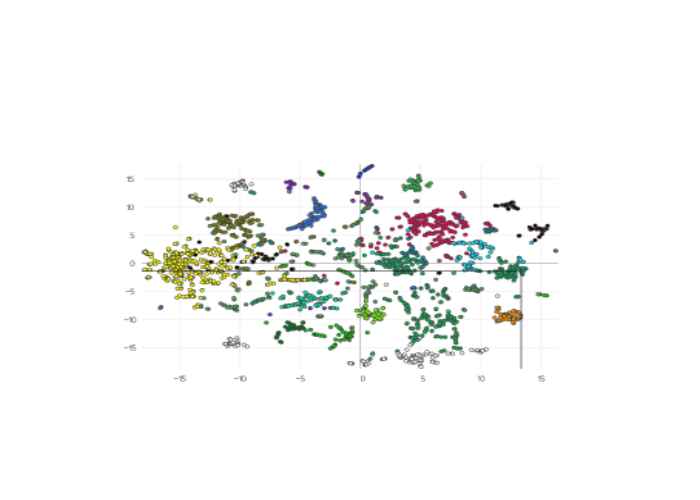

In [8]:
data = model.plot_trace()

py.image.ishow({'data': data})
# uncomment this line below (and comment the one above) to have the interactive plot
py.iplot(data)

## A more tuned example

Ok now, we're loading all the file and creating our data structures all the way again:

In [9]:
dir_path = os.getcwd() + "/../dataset/cs.illinois.edu/no_constraint/words1000_depth10/"

vertex_path      = dir_path + "vertex.txt"
codecontent_map  = get_content_map(vertex_path)

map_path         = dir_path + "urlsMap.txt"
codeurl_map      = get_urlmap(map_path)

sequences_path   = dir_path + "sequenceIDs.txt"
sequences        = get_sequences(sequences_path)

gt = GroundTruth(os.getcwd() + "/../dataset/cs.illinois.edu/ground_truth/urlToMembership.txt")
ground_truth = [ int(gt.get_groundtruth(codeurl_map[code])) for code in codeurl_map ]
len(ground_truth)

728

Tuning some parameters:
- **algorithm** passed now is KMeans with 15 desired clusters (because of reasons)


- **e_sg** = 1 means that we ar using skip-gram for training word2vec model


- **e_min_count** = 5, we are ignorig all words with total frequency lower than 5 for training word2vec model


- **e_window** = 5, now we're considering a shorter distance (default 10) between a word and its neighboring when learning a feature vector for that word (word2vec)


- **e-size** the size of the word2vec feature vectors, or in another point of view, the importance we want to give to the URL embedding approach


- **d_dim_red** the size of the feature vectors from the tf-idf matrix(in this case), or else, the importance we want to give to the page content and the words in it.



The other parameters are listed but left unchanged. Here are set 36 for word2vec vectors and 64 for tf-idf vectors, so giving more importance to the page content.

In [10]:
model = Url2Vec(codeurl_map)
predicted_labels = model.train(
    sequences = sequences, 
    contents = codecontent_map, 
    algorithm = KMeans(n_clusters=15), 
    use_w2v = True, 
    use_tfidf = True,      
    e_sg = 1, 
    e_min_count = 5, 
    e_window = 5, 
    e_negative = 5, 
    e_size = 36, 
    d_max_df = 0.9, 
    d_max_features = 200000, 
    d_min_df = 0.05, 
    d_dim_red = 64, 
    d_tfidf = True
)

len(predicted_labels)

AttributeError: Url2Vec instance has no attribute 'train'

Now we have the predicted labels, clustered with KMeans:

In [ ]:
print("Clusters found with KMeans:", len(set(predicted_labels)))
print(set(predicted_labels), "\n")
print(predicted_labels[:15])

print("\n\n")

#### Confusion table
Now we can reconsider the confusion table by passing the ground truth:

In [ ]:
conf_table = model.test(ground_truth)
pd.DataFrame(conf_table, index=set(ground_truth), columns=set(predicted_labels))

#### Other metrics
As well as the other metrics:

In [ ]:
homogeneity     = model.homogeneity_score()
completeness    = model.completeness_score()
v_measure       = model.v_measure_score()
adj_rand        = model.adjusted_rand_score()
adj_mutual_info = model.adjusted_mutual_info_score()
silhouette      = model.silhouette_score()

pd.DataFrame({
        "Homogeneity":homogeneity, 
        "Completeness":completeness, 
        "V-Measure":v_measure, 
        "Adj Rand index":adj_rand, 
        "Adj Mutual info":adj_mutual_info, 
        "Silhouette":silhouette
    },
    index=["Model Scores"]
)

And finally we can plot everything:

In [ ]:
twodim = model.two_dim()
data = model.plot_trace()

# py.image.ishow({'data': data})
# uncomment this line below (and comment the one above) to have the interactive plot
py.iplot(data)